In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Basic settings

In [2]:
# set the parameters
x0 = 1 
L = 1 
M =1
R = -3
F = 1
C = -10
D = -5
T = 1

epsilon = 10**(-4)# stopping criteria
delta = 10**(-4) # udpating rate

## Our model
Our deterministic SDE is given by
$$d X_{t}=\left[L(t) X_{t}+M(t) \alpha_{t}\right] d t,\text{ for $t\in [0,T]$ }\quad X_0=x_0$$
Where $L=L(t)\in \mathbb{R}$, $M=M(t)\in \mathbb{R}$ are bounded and deterministic function of t, in our settings, we set them to be constant(the same argument on $F,C,D$).

The running reward $f$:
$$f(t,X_{t},\alpha_{t})=C(t) X^2_{t}+D(t) \alpha^2_{t}+2 X_{t} F(t) \alpha_{t}$$
Further let $C=C(t) \in \mathbb{R}, D=D(t) \in \mathbb{R}, F=F(t) \in \mathbb{R}$ be deterministic, integrable functions of $t$and $R \in \mathbb{R}$ be such that $C, D$ and $R$ are symmetric, $C=C(t) \leq 0, R \leq 0$ and $D=D(t) \leq-\delta<0$ with some constant $\delta>0 .$ The aim will be to maximize
$$
\begin{aligned}
J^{\alpha}(x):=\mathbb{E}^{x, \alpha}\left[\int_{0}^{T}\left[C(t) X^2_{t}+D(t) \alpha^2_{t}+2 X_{t} F(t) \alpha_{t}\right] d t+X_{T}^{2} R\right]\\
\text { over all adapted processes } \alpha \text { such that } \mathbb{E} \int_{0}^{T} \alpha_{t}^{2} d t<\infty
\end{aligned}
$$

Let $b(t,X_{t},\alpha_{t})=L(t) X_{t}+M(t) \alpha_{t}$

The Hamiltonian is
$$
H_t(x,y,a)=b(t,x,a)y+f(t,x,a)
$$
We have 
$$\partial_{x} H_{t}(x, a, y)=L(t) y+2 C(t) x+2 F(t) a$$
So the adjoint BSDE $\hat{Y}$ for the optimal control $\hat{\alpha}$ is
$$
d \hat{Y}_{t}=-\left[L(t) \hat{Y}_{t}+2 C(t) \hat{X}_{t}+2 F(t) \hat{\alpha}\right]d t \text { for } t \in[0, T], \quad \hat{Y}_{T}=2 R \hat{X}_{T}
$$
Since $C\leq0$ we have that $H$ is concave, so the Pontryagin's maximum principle applies here, if $\hat{\alpha}_t$ is the optimal control and $\hat{X_t}$ is the associated diffusion and $\hat{Y_t}$ is the colution of the BSDE, we will have
$$H_{t}\left(\hat{X}_{t}, \hat{\alpha}_{t}, \hat{Y}_{t}\right)=\max _{a \in \mathbb{R}} H_{t}\left(\hat{X}_{t}, a, \hat{Y}_{t}\right)$$

First solve the $\hat X_t$ and $\hat Y_t$ numerically

In [3]:
def update_x(X,alpha,N):
    dt = float(T)/N
    for i in range(1,N):
        X[i] = X[i-1] + (L * X[i-1] + M * alpha[i-1]) * dt
    return X

In [4]:
def update_y(Y,X,alpha,N):
    dt = float(T)/N
    Y[-1] = 2*R*X[-1]
    for i in range(N-2,-1,-1):
        Y[i] = Y[i+1] + (L*Y[i+1] + 2*C*X[i+1] + 2*F*alpha[i+1]) * dt
    return Y

## STEP 2

We have $\partial_a H=My+2Da+2FX$ and the update rule
$$\alpha_{t}^{(j)}=\alpha_{t}^{(j-1)}+\delta\left(\nabla_{a} H\right)\left(t, X_{t}^{(j)}, Y_{t}^{(j)}, \alpha_{t}^{(j-1)}\right)$$
Together with the function $J$, we have the following algorithm

In [5]:
def MSE_solution(N=100):
    X = np.zeros(N)
    X[0] = x0
    alpha = 0.5 * np.ones(N)
    dt = float(T)/N
    t=np.linspace(0,T,N)
    flag = True
    count = 0
    while flag == True:
        count += 1
        X = update_x(X,alpha,N)
        Y = np.zeros(N)
        Y = update_y(Y,X,alpha,N)

        for i in range(N):
            alpha[i] = alpha[i] + delta*(2*D*alpha[i]+2*F*X[i]+M*Y[i])

        P_J = np.sum((C*X**2 + D*alpha**2 + 2*F*X*alpha)*dt) + R*X[-1]**2

        if count == 1:
            J = P_J
            continue

        if J + epsilon > P_J:
            flag = False
            print("Solution convergent")
        elif P_J < J:
            flag = False
            print("Failed")
        if count > 10000:
            print('Too many iterations')
            break

        J = P_J
    return J, alpha, X, Y,count,t

In [6]:
J,alpha,X,Y,count,t = MSE_solution(N=100)
print(f'Number of ieration:{count}')
print(f'The maximized J is {J}')

Solution convergent
Number of ieration:995
The maximized J is -14.468154627270861


## Exact solution

Take the derivative of $H$ with respect to $a$ and let it equal to zero, we get 
$$\hat{\alpha}_{t}=-\frac{1}{2} D(t)^{-1}\left(M(t) \hat{Y}_{t}+2 F(t) \hat{X}_{t}\right)$$
Then we have 
$$d \hat{X}_{t}=\left\{L(t)+M(t)\left[-D(t)^{-1}\left(M(t) S(t)+F(t)\right)\right]\right\} \hat{X}_{t} d t$$
From the lecture notes, we guess $\hat{Y}_{t}=2 S(t) \hat{X}_{t}$ and finally, we can arrive the equation of $S_t$

$$
S^{\prime}(t)=[S(t) M(t)+F(t)] D(t)^{-1}\left(M(t) S(t)+F(t)\right)-2L(t) S(t)-C(t), \ t\in[0,T],\ S(T)=R
$$

In [7]:
def exact_solution(N=100):
    S = np.zeros(N)
    S[-1] = R
    dt = float(T)/N
    t=np.linspace(0,T,N)
    for i in range(N-2,-1,-1):
        S[i] = S[i+1] - ((S[i+1]*M+F)/D*(M*S[i+1]+F)-2*L*S[i+1]-C)*dt

    X_hat = np.zeros(N)
    X_hat[0] = x0
    for i in range(N-1):
        X_hat[i+1] = (L + M * (-1/D*(M*S[i] + F))) * X_hat[i] * dt + X_hat[i]
    alpha_true = -(M*S+F)/D*X_hat
    return alpha_true,t,X_hat

In [8]:
alpha_true,t,X_hat = exact_solution()
dt = float(T)/100

In [9]:
J_exact = np.sum((C*X_hat**2 + D*alpha_true**2 + 2*F*X_hat*alpha_true)*dt) + R*X_hat[-1]**2
print(f'The true optimal J is {J_exact}')

The true optimal J is -14.452554741401936


#### Plot of exact $\alpha$ and approximated $\alpha$

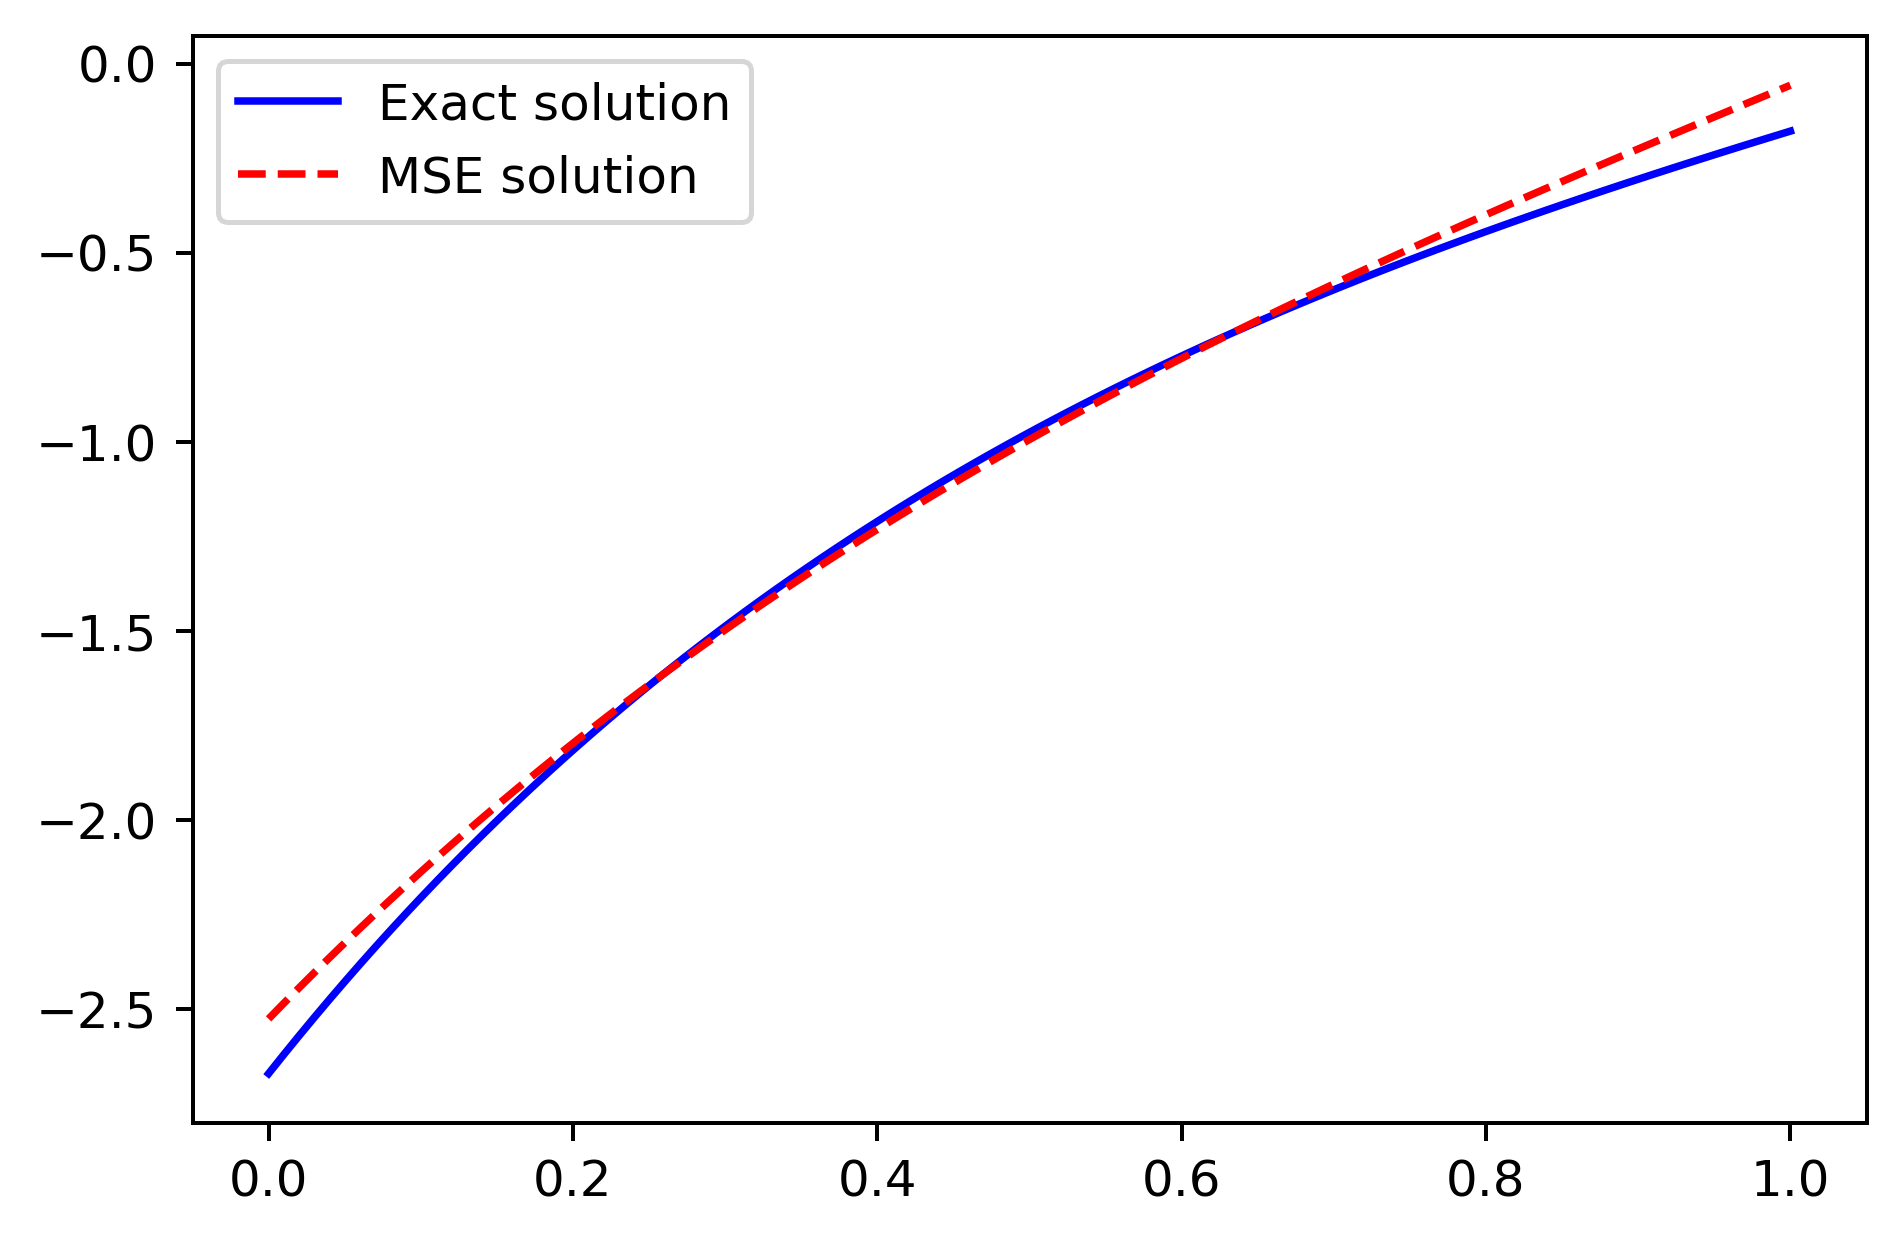

In [10]:
plt.figure(dpi=360)
l1,=plt.plot(t,alpha_true,'b-')
l2,=plt.plot(t,alpha,'r--')
plt.legend(handles=[l1,l2,],labels=['Exact solution','MSE solution'],loc='best')

### Analysis of the convergence
We compare the error of $\alpha$ instead of $J$ for convenience.

In [11]:
def get_error(N=100):
    J,alpha,X,Y,count,t = MSE_solution(N)
    alpha_true,t,X_hat = exact_solution(N)
    square_difference = np.square(alpha_true-alpha)
    error = np.sum(square_difference)/N
    return error

#### Warning
The cell may take 1 minute to run

In [12]:
N = [i*100 for i in range(1,16)]
error = []
for i in range(15):
    error.append(get_error(N[i]))

Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent


Text(0, 0.5, 'Error')

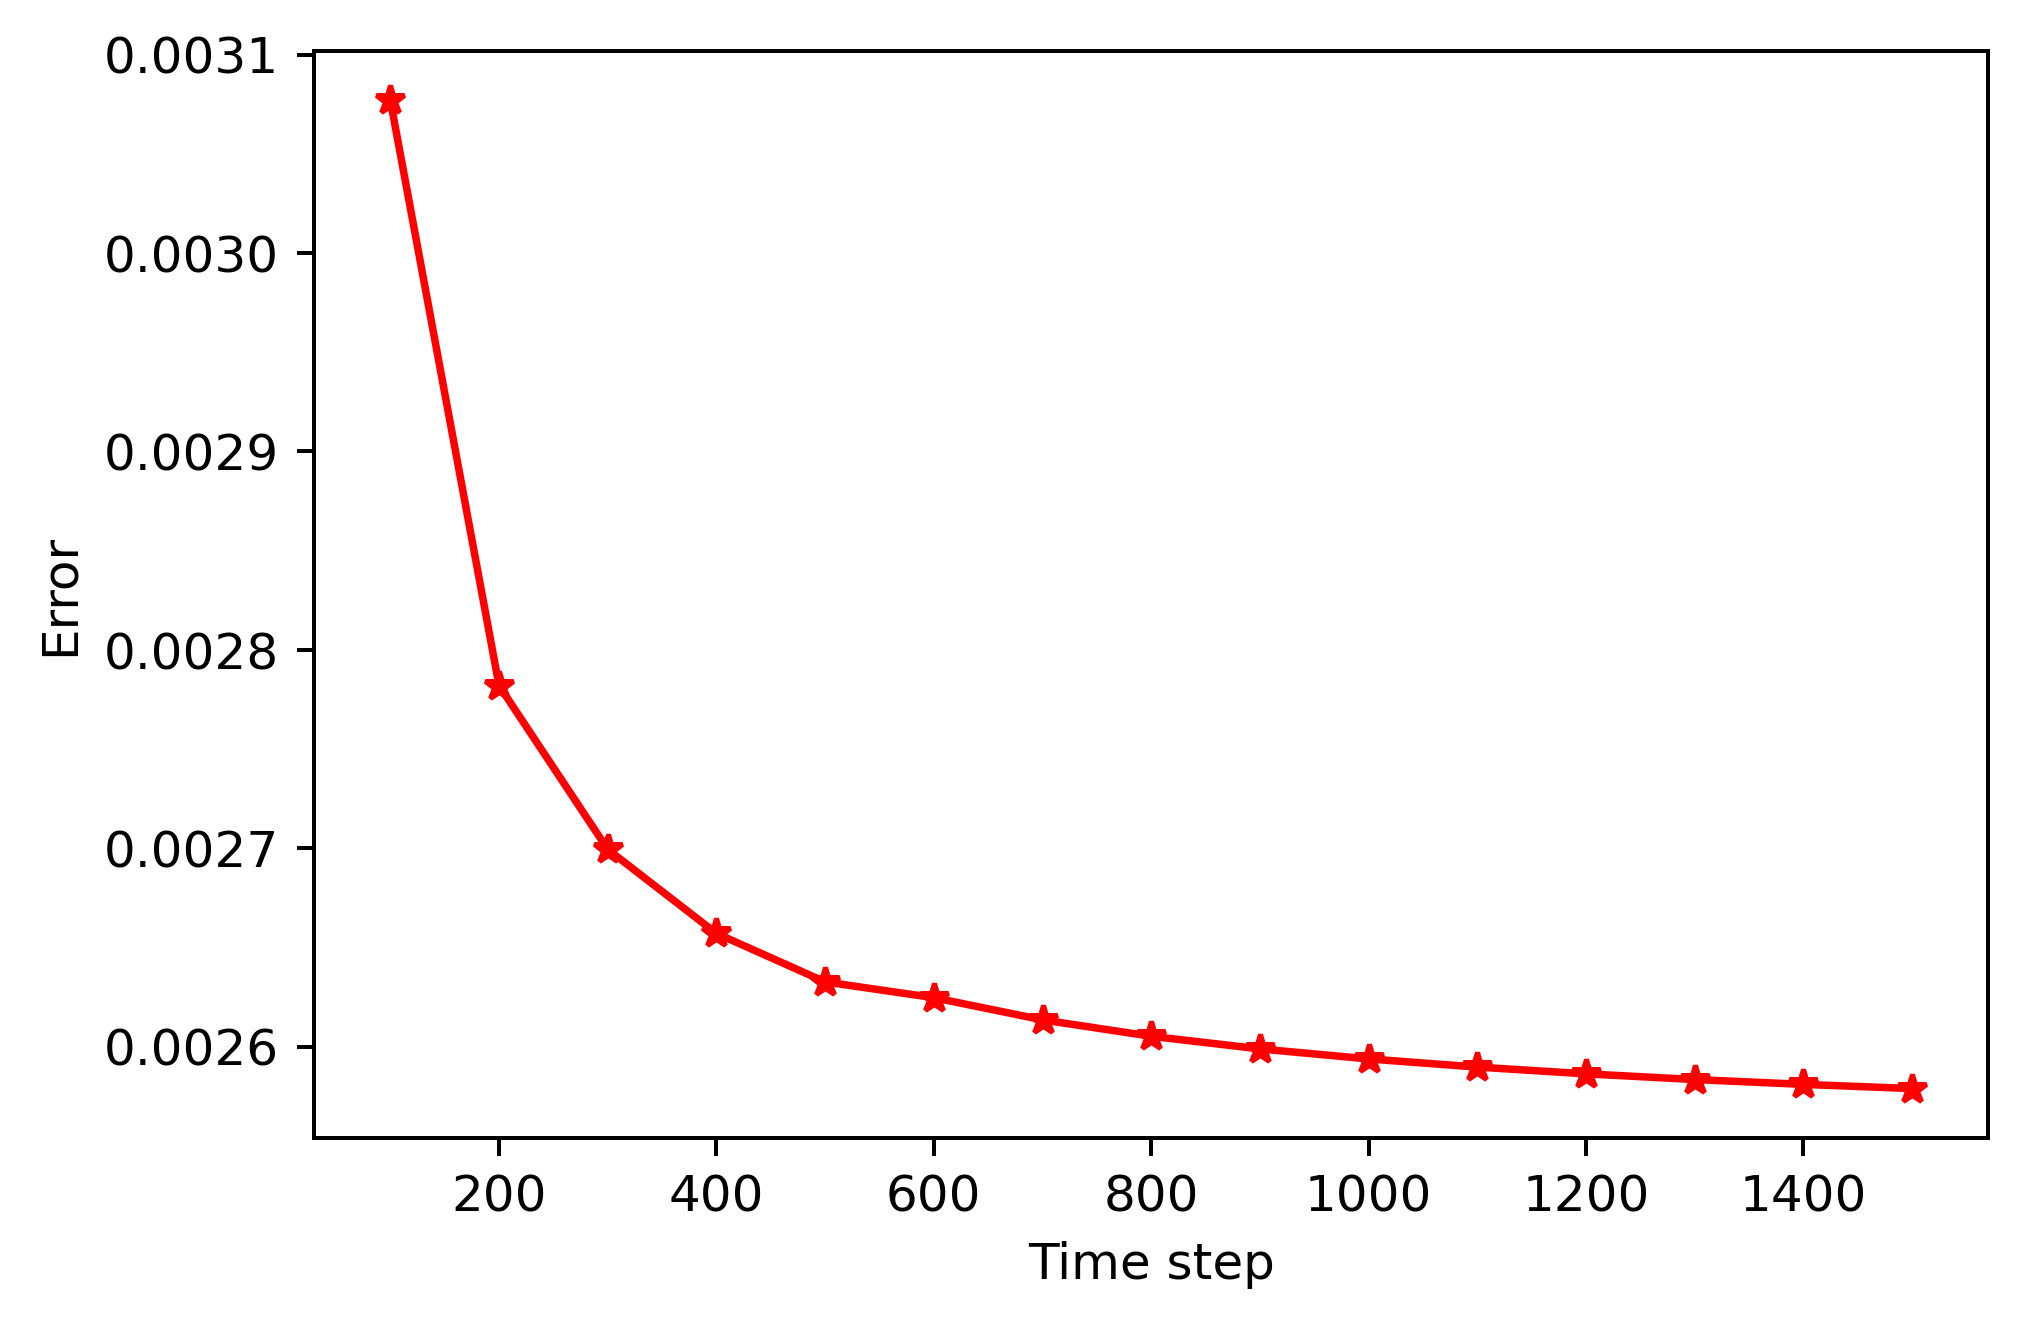

In [14]:
plt.figure(dpi=360)
plt.plot(N,error,'r*-')
plt.xlabel('Time step')
plt.ylabel('Error')

## Discussion

We can see that the approximated solution is very close to the exact solution, and the MSA algorithm convergent well. As the time step increase, the mean square error get smaller. And we will get the more accurate $J$ as the number of time step goes up.